In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
The data has been collected by hand as it was formatted differently for nearly every row. Some points have been imputed by hand elsewhere, based off of photos, educated guesses and industry knowledge. Enough data has been collected so that feature engineering is now underway. One major point is how to encompass the information about number of doors and windows, experimenting with different ways of tackling these columns is currently underway. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height highest point,Usage Intent- On or Off Road,A/C,Roof Rack,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,Yes,Option,Yes,Yes,No,Yes,Yes,Yes,0,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                      object
model                             object
total dry weight                   int64
length                           float64
Cabin exterior width             float64
exterior height                  float64
interior height highest point    float64
Usage Intent- On or Off Road      object
A/C                               object
Roof Rack                         object
Driver Side Window                 int64
Driver Side Door                   int64
Driver Side Door Window            int64
Passenger Side Door                int64
Passenger Side Door Window         int64
Passenger Side Window              int64
Spare Tire                        object
Battery Power Supply              object
Cabinets                          object
Refrigerator                      object
Awning                            object
Solar                             object
STOVE                             object
USB Charging                      object
USB Cost        

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                     0
model                            5
total dry weight                 0
length                           0
Cabin exterior width             0
exterior height                  0
interior height highest point    0
Usage Intent- On or Off Road     0
A/C                              0
Roof Rack                        0
Driver Side Window               0
Driver Side Door                 0
Driver Side Door Window          0
Passenger Side Door              0
Passenger Side Door Window       0
Passenger Side Window            0
Spare Tire                       0
Battery Power Supply             0
Cabinets                         0
Refrigerator                     0
Awning                           0
Solar                            0
STOVE                            0
USB Charging                     0
USB Cost                         0
Base price                       0
dtype: int64

There are no missing values because the data has been imputed by hand beforehand. 

In [5]:
data.shape

(96, 26)

In [6]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [7]:
#checking the categories are clean
data['Passenger Side Door Window'].value_counts()

2    71
1    19
0     6
Name: Passenger Side Door Window, dtype: int64

In [8]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

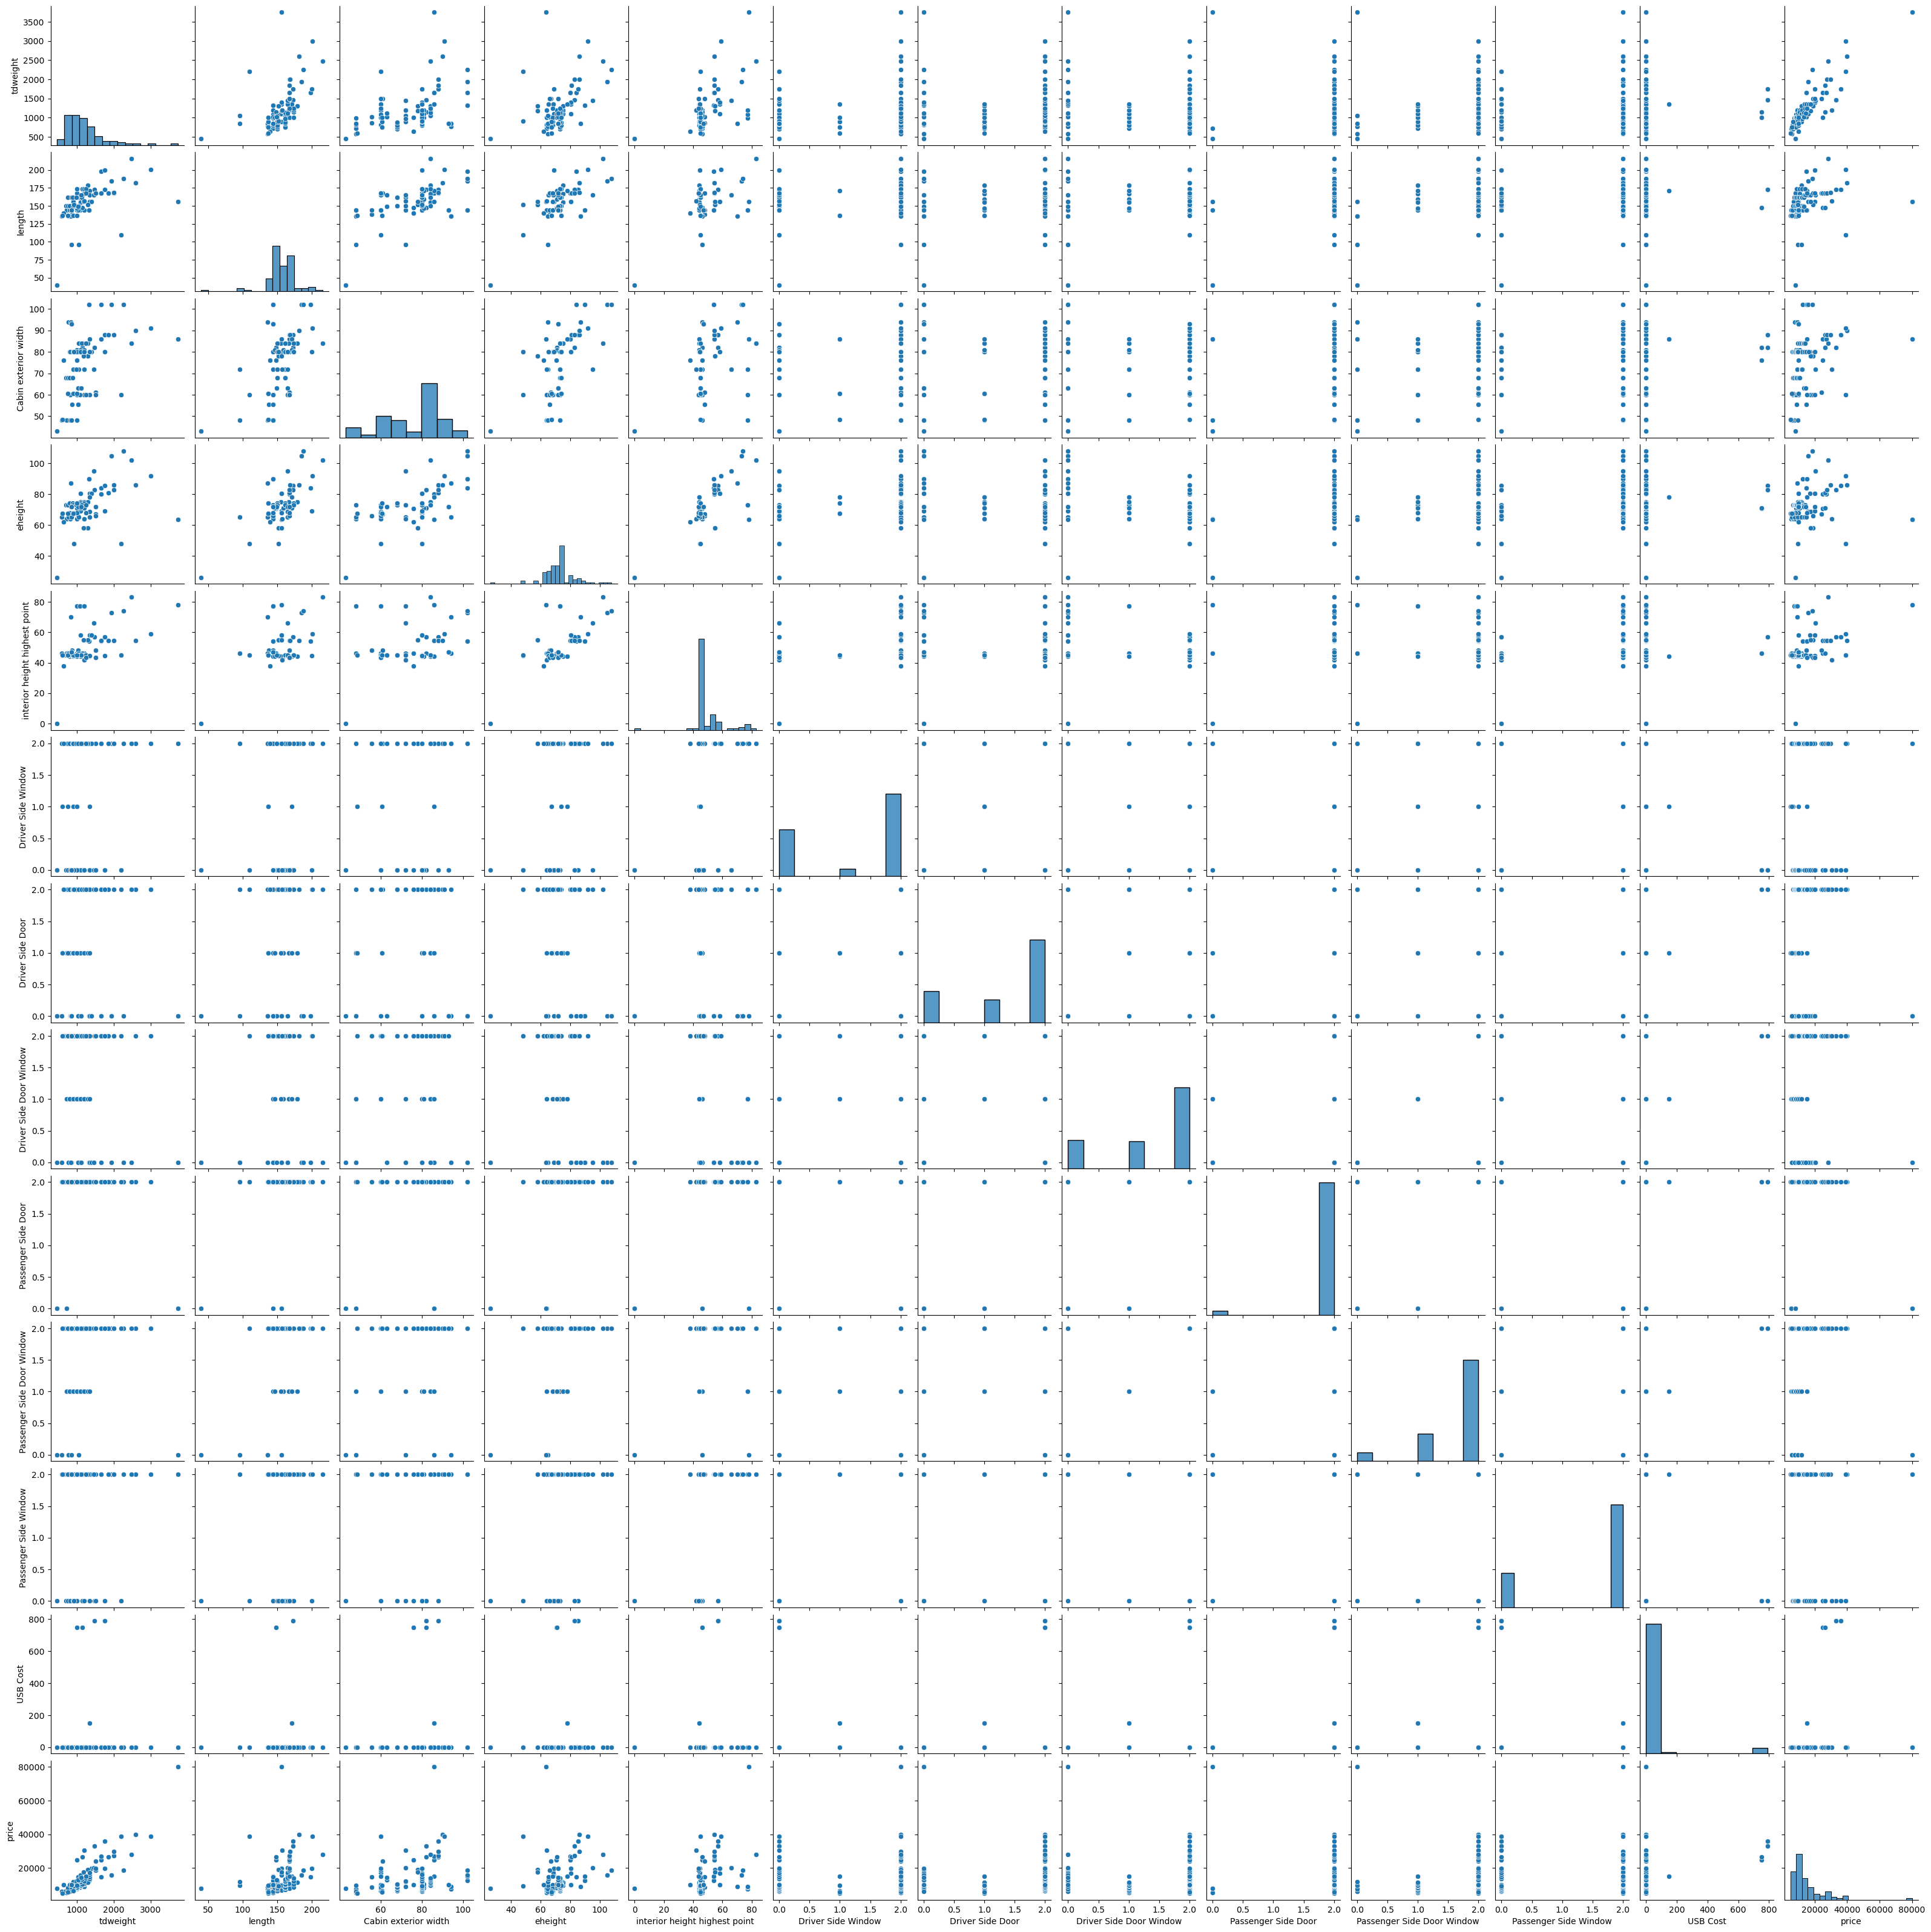

In [9]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

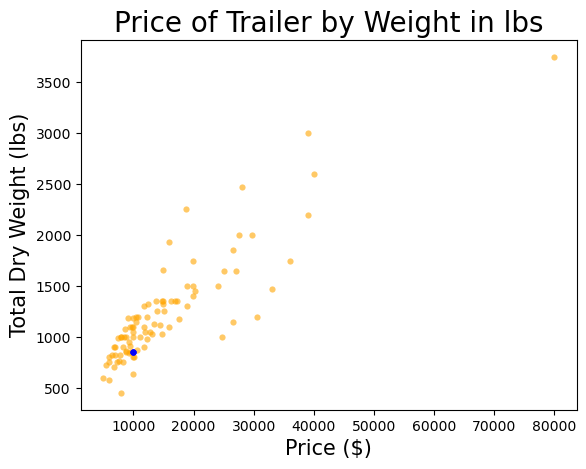

In [10]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

Now let's look at how a few features map onto the weight vs. price

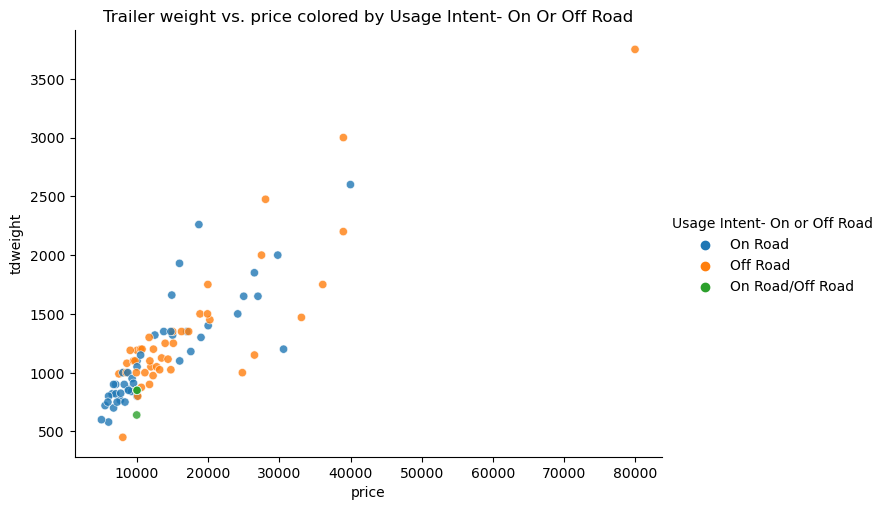

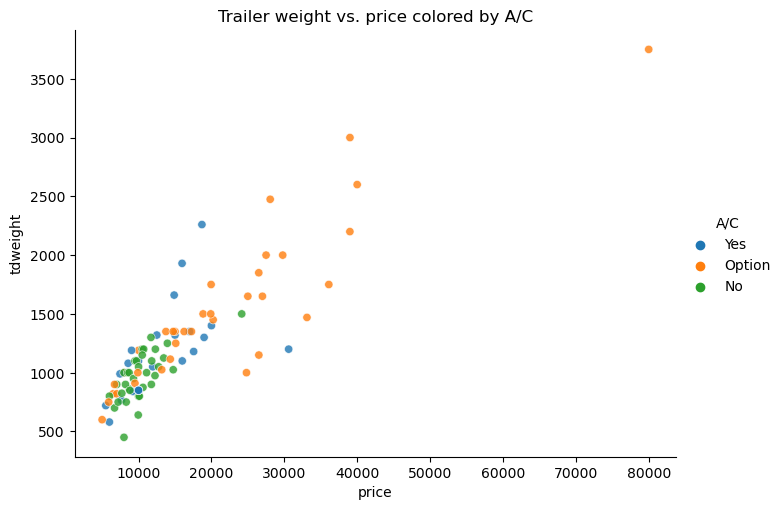

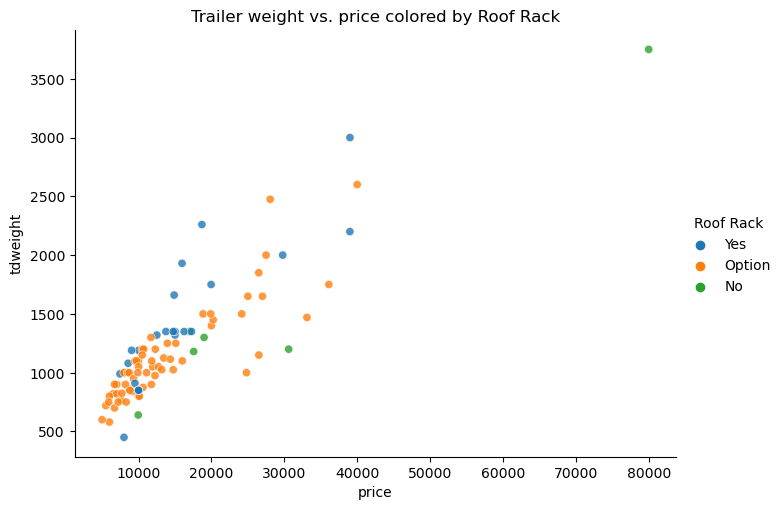

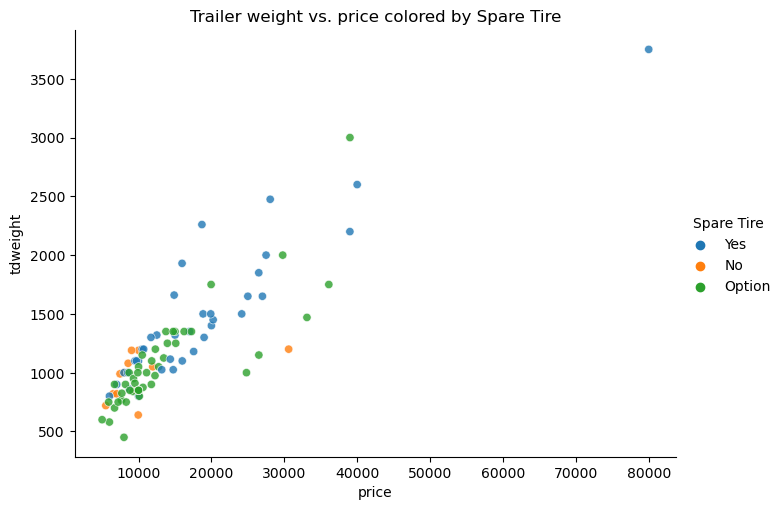

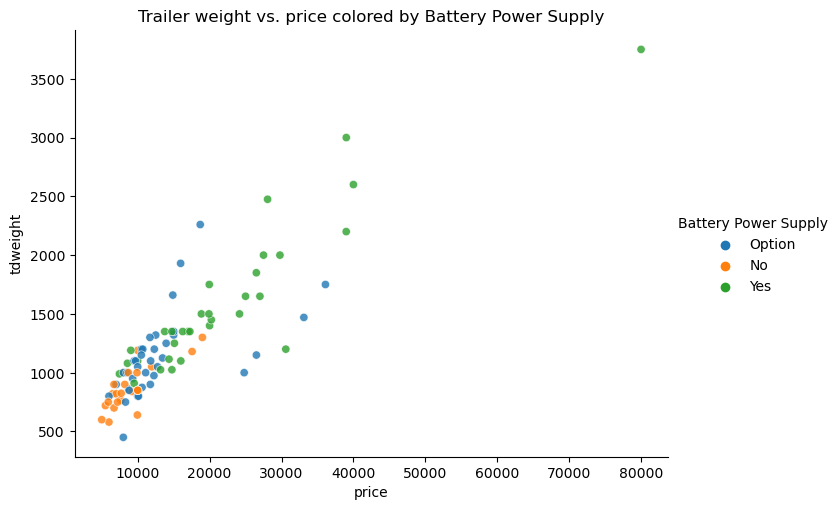

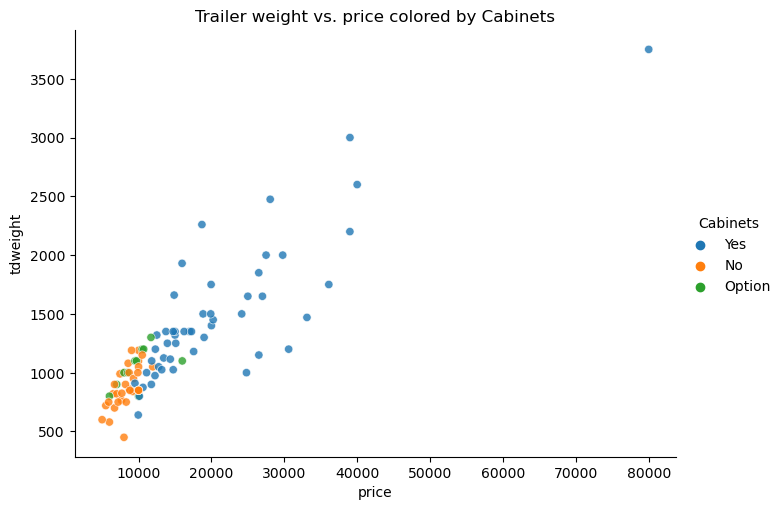

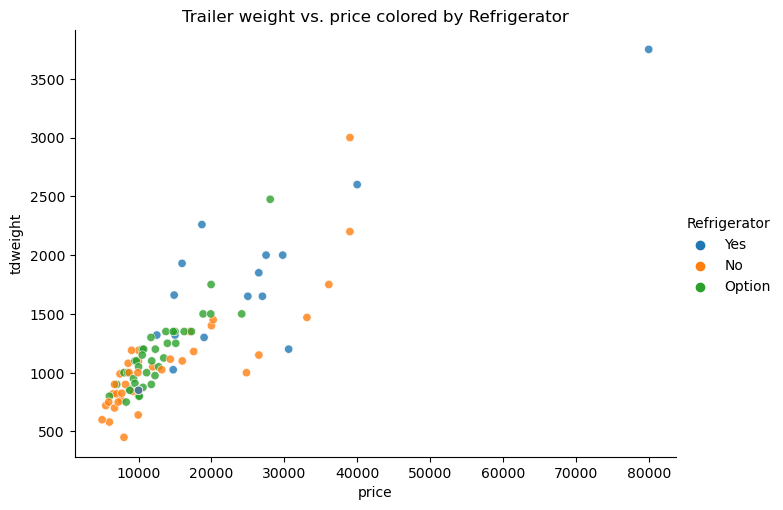

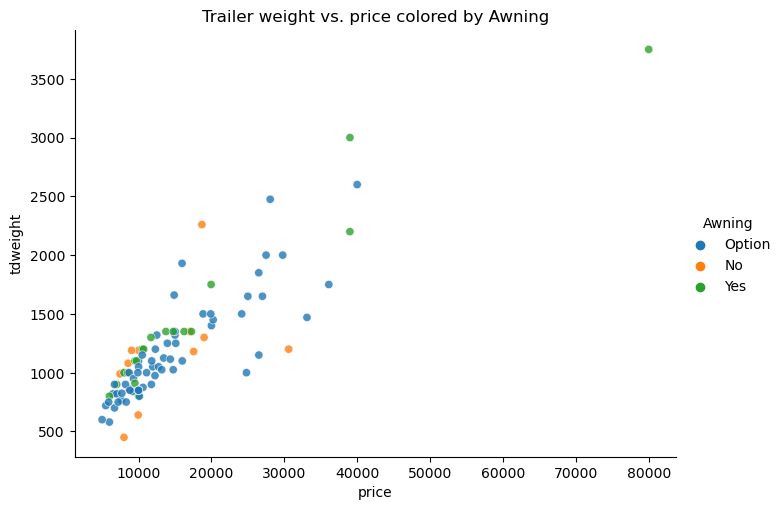

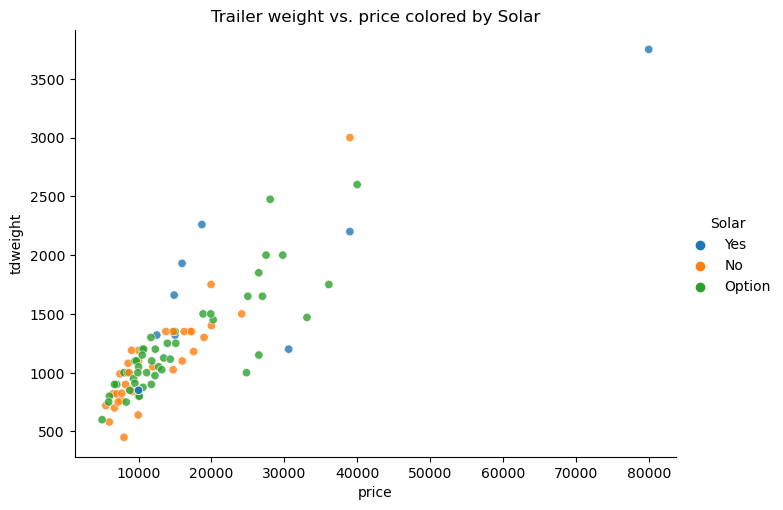

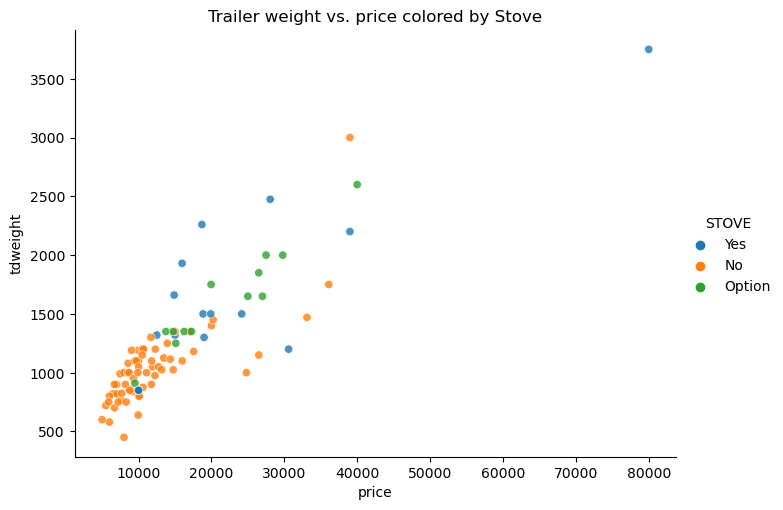

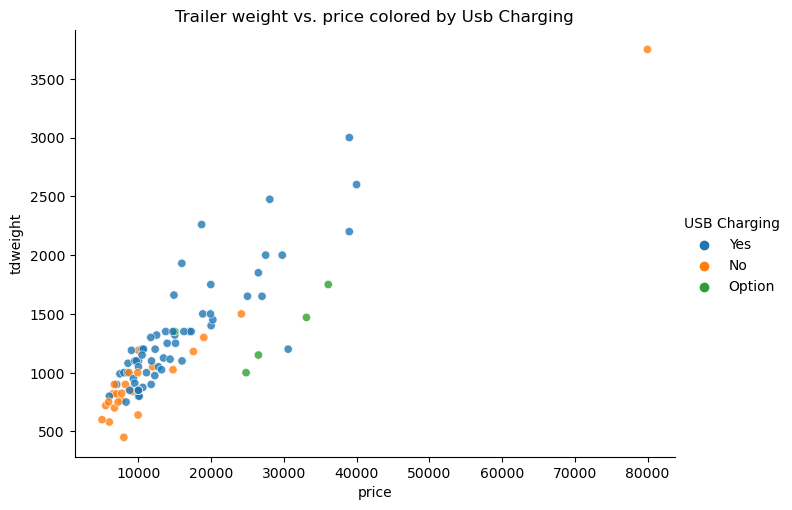

In [11]:
for c in ['Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.8)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [12]:
#These features are highly negatively correlated and contain rather repetitive data
#Relevant columns are added together to reduce complexity
#No:0, Option:1, Yes:2
data["Windows"] = data["Driver Side Window"] + data["Passenger Side Window"]
data["Doors"] = data["Driver Side Door"] + data["Passenger Side Door"]
data["Door Windows"] = data["Driver Side Door Window"] + data["Passenger Side Door Window"]

In [13]:
#reorder the columns so there are no problems with slicing/encoding
data = data[['tdweight', 'length', 'Cabin exterior width', 'eheight', 'interior height highest point', 'Windows', 'Doors', 'Door Windows', 'Usage Intent- On or Off Road', 'A/C', 'Roof Rack', 'Spare Tire', 'Battery Power Supply', 'Cabinets', 'Refrigerator', 'Awning', 'Solar', 'STOVE', 'USB Charging', 'USB Cost', 'price']]

In [14]:
#checking the columns are reordered
data

,tdweight,length,Cabin exterior width,eheight,interior height highest point,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
0,1660,198.0,102.0,84.0,54.0,4,2,2,On Road,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14879
1,1320,144.0,102.0,90.0,54.0,4,2,2,On Road,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,12500
2,1320,144.0,102.0,90.0,54.0,4,2,2,On Road,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,14997
3,1930,185.0,102.0,105.0,73.0,4,2,2,On Road,Yes,...,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes,0,15965
4,2260,188.0,102.0,108.0,74.0,4,2,2,On Road,Yes,...,Yes,Option,Yes,Yes,No,Yes,Yes,Yes,0,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,850,144.0,93.0,72.0,47.0,2,2,4,On Road/Off Road,Yes,...,Option,No,No,No,Option,No,No,No,0,9995
92,850,144.0,93.0,72.0,47.0,2,2,4,On Road/Off Road,Yes,...,Option,No,No,No,Option,No,No,Yes,0,9995
93,850,144.0,93.0,72.0,47.0,2,2,4,On Road/Off Road,Yes,...,Option,No,No,No,Option,No,Yes,Yes,0,9995
94,850,144.0,93.0,72.0,47.0,2,2,4,On Road/Off Road,Yes,...,Option,No,No,No,Option,Yes,Yes,Yes,0,9995


In [15]:
#select the categorical data for encoding
cat_data = data.iloc[:, 8:19]
cat_data

,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging
0,On Road,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
1,On Road,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
2,On Road,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
3,On Road,Yes,Yes,Yes,Option,Yes,Yes,Option,Yes,Yes,Yes
4,On Road,Yes,Yes,Yes,Option,Yes,Yes,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...
91,On Road/Off Road,Yes,Yes,Option,No,No,No,Option,No,No,No
92,On Road/Off Road,Yes,Yes,Option,No,No,No,Option,No,No,Yes
93,On Road/Off Road,Yes,Yes,Option,No,No,No,Option,No,Yes,Yes
94,On Road/Off Road,Yes,Yes,Option,No,No,No,Option,Yes,Yes,Yes


In [16]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tdweight,length,Cabin exterior width,eheight,interior height highest point,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,...,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,USB Cost,price
0,1660,198.0,102.0,84.0,54.0,4,2,2,1,2,...,2,1,2,2,1,2,2,2,0,14879
1,1320,144.0,102.0,90.0,54.0,4,2,2,1,2,...,2,1,2,2,1,2,2,2,0,12500
2,1320,144.0,102.0,90.0,54.0,4,2,2,1,2,...,2,1,2,2,1,2,2,2,0,14997
3,1930,185.0,102.0,105.0,73.0,4,2,2,1,2,...,2,1,2,2,1,2,2,2,0,15965
4,2260,188.0,102.0,108.0,74.0,4,2,2,1,2,...,2,1,2,2,0,2,2,2,0,18689


In [17]:
#dropping columns which aren't useful or have very negative correlations
data = data.drop(['interior height highest point', 'USB Cost'], axis=1)
#, 'Roof Rack', 'Usage Intent- On or Off Road', 'A/C'

In [18]:
#make a copy of the data for later
data2=data

In [19]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
tdweight,1.000000,0.521120,0.383462,0.437361,0.122807,0.004440,-0.007877,-0.241925,0.159684,0.067950,0.382148,0.554536,0.548321,0.436766,0.178002,0.332057,0.513358,0.268035,0.876003
length,0.521120,1.000000,0.469431,0.645245,0.067596,0.320769,0.337253,-0.057785,-0.103066,-0.006574,0.330261,0.373805,0.471059,0.392385,0.225914,0.227764,0.244650,0.443257,0.299917
Cabin exterior width,0.383462,0.469431,1.000000,0.576307,0.040095,-0.091426,0.090875,0.294119,0.152444,0.182286,0.378452,0.056221,0.310798,0.424305,0.183494,0.391910,0.321489,0.409569,0.258535
eheight,0.437361,0.645245,0.576307,1.000000,0.301531,0.032109,0.040724,0.015861,0.180372,0.123908,0.291755,0.181967,0.261529,0.294331,-0.037643,0.328066,0.186338,0.368576,0.196200
Windows,0.122807,0.067596,0.040095,0.301531,1.000000,-0.107581,-0.231591,-0.044626,0.147998,-0.180301,0.027938,0.001573,-0.002722,0.185779,-0.338356,0.051074,-0.099546,0.037088,-0.022516
Doors,0.004440,0.320769,-0.091426,0.032109,-0.107581,1.000000,0.579598,-0.262424,-0.395305,-0.119503,-0.190360,0.170468,0.211585,0.075416,-0.009698,-0.137311,-0.127319,0.107624,-0.007636
Door Windows,-0.007877,0.337253,0.090875,0.040724,-0.231591,0.579598,1.000000,0.160959,-0.305940,-0.002998,-0.032803,0.072809,0.239201,0.159263,-0.007703,0.076020,0.113690,0.158600,0.059804
Usage Intent- On or Off Road,-0.241925,-0.057785,0.294119,0.015861,-0.044626,-0.262424,0.160959,1.000000,0.290159,0.055541,0.004043,-0.373408,-0.350725,0.010336,-0.147915,-0.063466,0.209351,-0.148366,-0.222513
A/C,0.159684,-0.103066,0.152444,0.180372,0.147998,-0.395305,-0.305940,0.290159,1.000000,0.266335,-0.111879,-0.008937,-0.065146,-0.116270,-0.363035,-0.053625,0.383133,-0.054205,0.131705
Roof Rack,0.067950,-0.006574,0.182286,0.123908,-0.180301,-0.119503,-0.002998,0.055541,0.266335,1.000000,-0.145439,0.125259,-0.083640,0.030755,0.156248,0.046802,0.258656,0.283178,-0.141106


<AxesSubplot:>

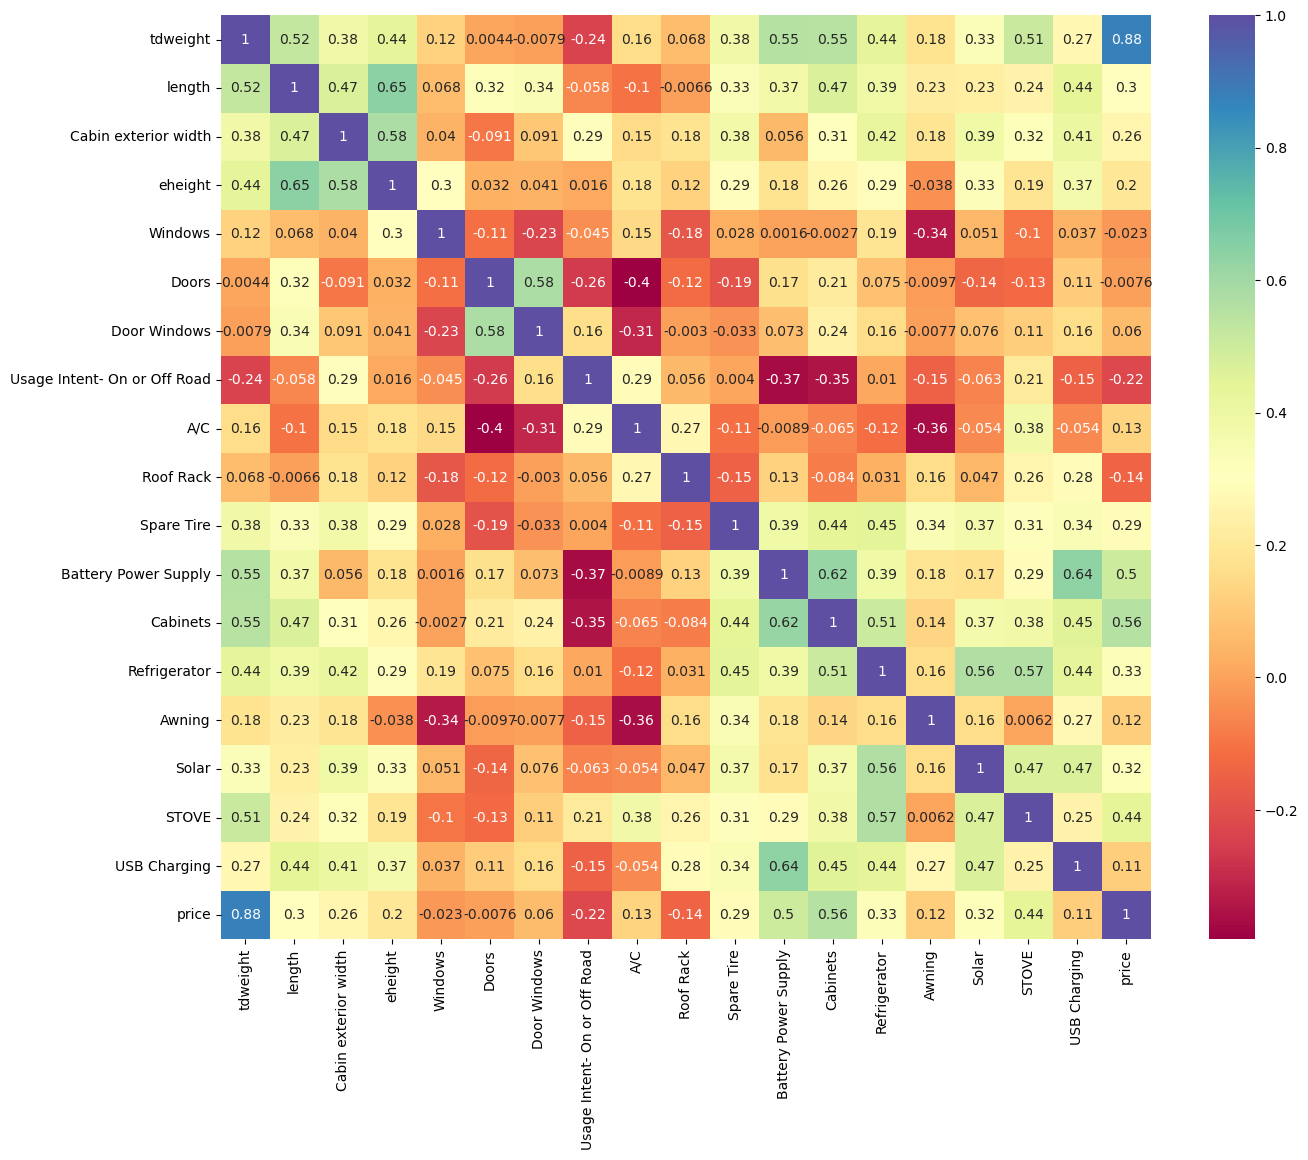

In [20]:
plt.figure(figsize=(15,12))
sns.heatmap(corr,annot=True,cmap="Spectral")

The concept of correlation measures the degree of association between features or the target variable. It can either be positive, which means an increase in the value of one feature results in an increase in the target variable, or negative, where an increase in the value of one feature results in a decrease in the target variable.

By plotting a heatmap of correlated features using the Seaborn library, it becomes easier to determine which features are strongly related to the target variable.

Here we can see that the weight has by far the largest correlation with price, however some luxury features like battery power supply, cabinets and stove also have a high correlation with price. 

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [21]:
data2=data2.drop(data.index[91:])

In [22]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price'],axis=1)
y=data2['price']

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [24]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    #EVALUATION OF THE MODEL
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    # Plotting y_test and y_pred 
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output common regression metrics: 



*Mean Absolute Error (MAE)* is the mean of the absolute value of the errors

*Mean Squared Error (MSE)* is the mean of the squared errors

*Root Mean Squared Error (RMSE)* is the square root of the mean of the squared errors

**The metrics compared:**

In comparing different metrics, the MAE represents the average error and is the most straightforward to comprehend. Meanwhile, the MSE is more commonly used than MAE as it penalizes larger errors, making it more relevant in real-world scenarios. The RMSE, on the other hand, is more widely used than MSE since it can be interpreted in the same units as the "y" variable. All of these are considered loss functions, as the objective is to minimize their values.

R^2 :  0.8098835736630958
MAE : 2812.872065757655
MSE : 11561798.15167753
RMSE: 3400.264423787881


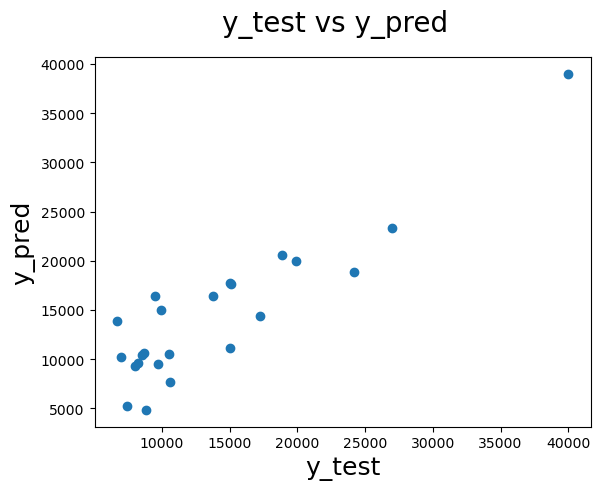

In [26]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.6448736398367039
MAE : 2812.4347826086955
MSE : 21596762.43478261
RMSE: 4647.231695835985


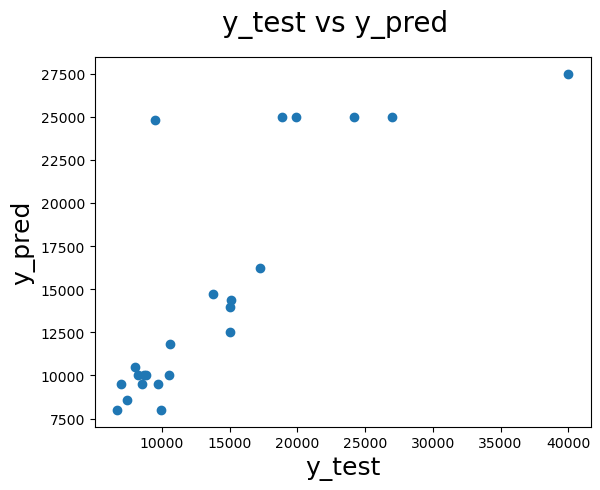

In [27]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5523204592042195
MAE : 4403.05129437431
MSE : 27225319.700382855
RMSE: 5217.788774987242


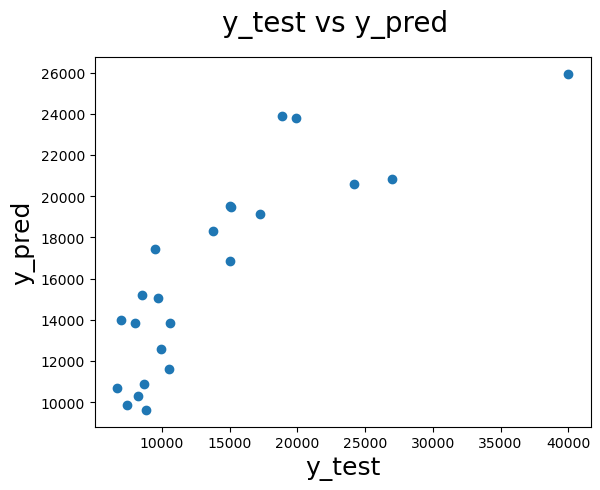

In [28]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.8895074576802443
MAE : 2320.020025811127
MSE : 6719527.061290676
RMSE: 2592.205057724152


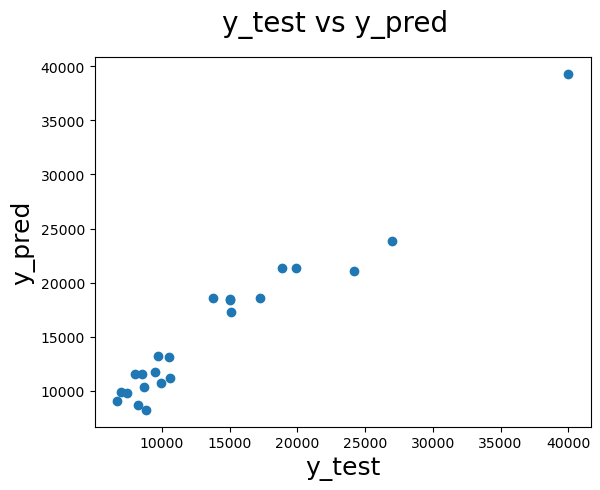

In [29]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.8185496898964294
MAE : 2825.928936484469
MSE : 11034774.324334903
RMSE: 3321.8630803112433


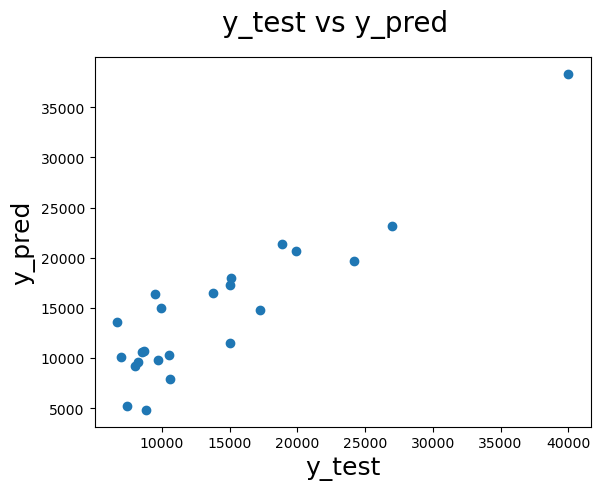

In [30]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.8189593112854439
MAE : 2828.3214171657764
MSE : 11009863.484647634
RMSE: 3318.111433428304


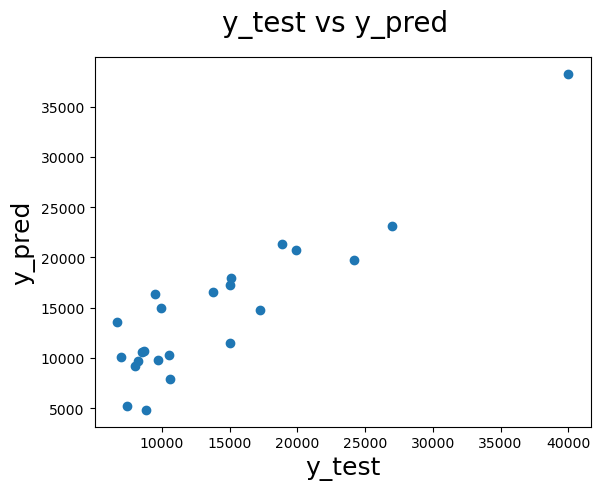

In [31]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.821202324090663
MAE : 2796.290549932934
MSE : 10873456.221975788
RMSE: 3297.4924142408254


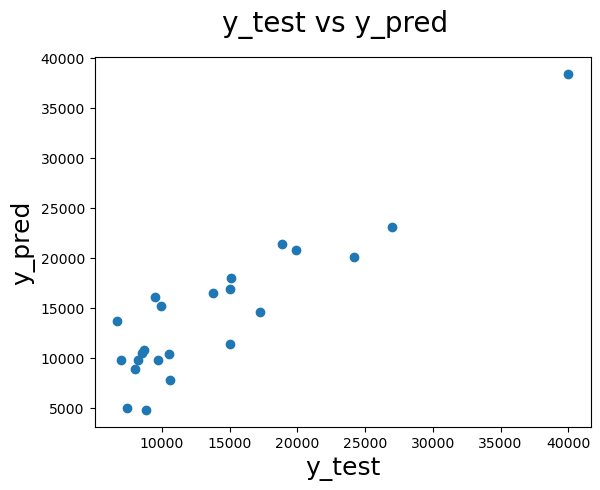

In [32]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.052021341614541416
MAE : 5593.312034379108
MSE : 63977945.71127635
RMSE: 7998.621488186346


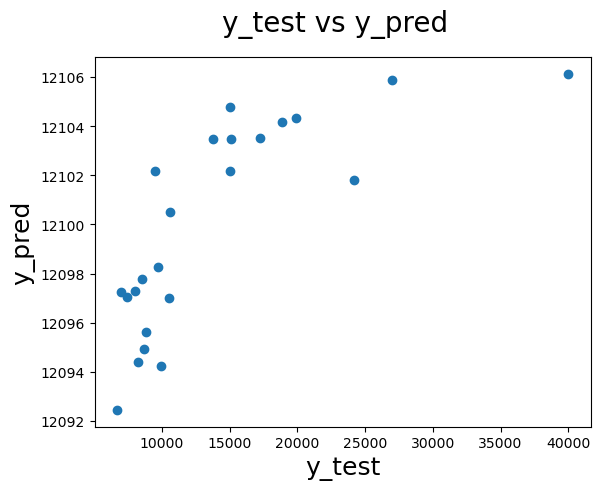

In [33]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7896024056532411
MAE : 2631.355775408167
MSE : 12795183.269040657
RMSE: 3577.0355420432516


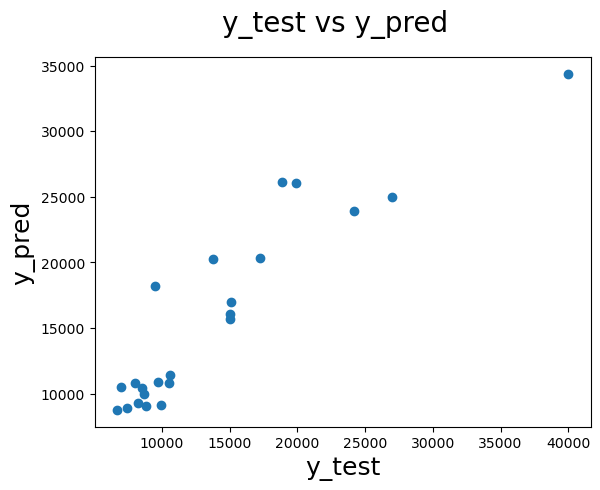

In [34]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

## Chi-squared (χ²) test

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

                           Specs         Score
0                       tdweight  20119.806455
1                         length    287.938202
2           Cabin exterior width    209.611473
3                        eheight    155.769411
16                         STOVE    111.500000
4                        Windows     84.198039
12                      Cabinets     60.752252
8                            A/C     60.681818
13                  Refrigerator     60.470588
17                  USB Charging     49.382114
15                         Solar     46.906250
11          Battery Power Supply     46.311881
6                   Door Windows     46.160584
7   Usage Intent- On or Off Road     44.968085
10                    Spare Tire     27.952586
14                        Awning     23.712121
5                          Doors     23.500000
9                      Roof Rack     19.800000


The *chi-squared (χ²) test* is a statistical hypothesis test used to determine the independence of two categorical variables. It is commonly used in machine learning to test the relationship between a feature and a target variable.

The chi-squared test is applicable only to non-negative features and is based on the assumption that the expected frequency of each category should be at least 5. If the expected frequency is less than 5, then the test result may not be reliable.

In the chi-squared test, the observed frequencies of each category are compared to the expected frequencies. The expected frequency of each category is calculated based on the null hypothesis of independence between the feature and the target variable. If the observed frequency significantly deviates from the expected frequency, then the null hypothesis is rejected, indicating that the feature is associated with the target variable.

The chi-squared test outputs a p-value, which represents the probability of observing the test results given that the null hypothesis is true. A small p-value indicates that the feature and target variable are likely associated, while a large p-value suggests that they are independent.

In general, a higher SelectKBest score indicates that the feature is more strongly associated with the target variable, and thus more relevant for the model. Conversely, a lower score indicates that the feature is less important for predicting the target variable.

## Extra Tree Classifier Top 10 Features 

[0.20847276 0.13991504 0.13043145 0.11190518 0.03499985 0.03120277
 0.03063569 0.04641805 0.02751696 0.02918811 0.03019416 0.02786254
 0.02587169 0.02614781 0.03282531 0.02446755 0.01989751 0.02204757]


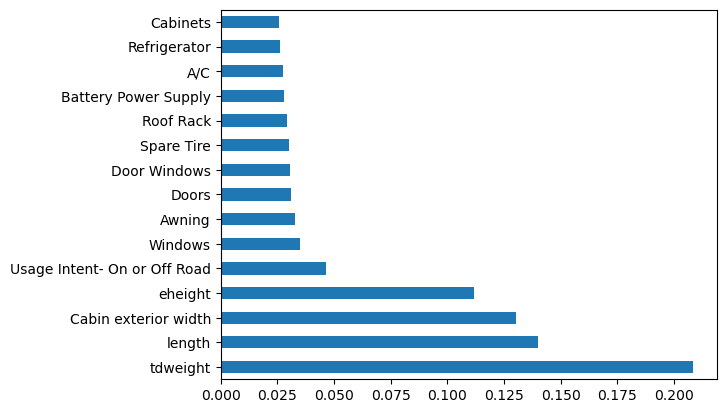

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

To obtain the feature importance of a dataset, one can utilize the feature importance property of the model being used. This property generates a score for each feature, with a higher score indicating greater importance or relevance to the output variable.

The feature importance function is a pre-existing class that is available in Tree-Based Classifiers. In this instance, we will utilize the Extra Tree Classifier to identify the top 10 features of the dataset.

We can see weight is still the most highly correlated to price, followed by other dimensions, On/Off Road and doors/windows.

## Correlation Heatmap 

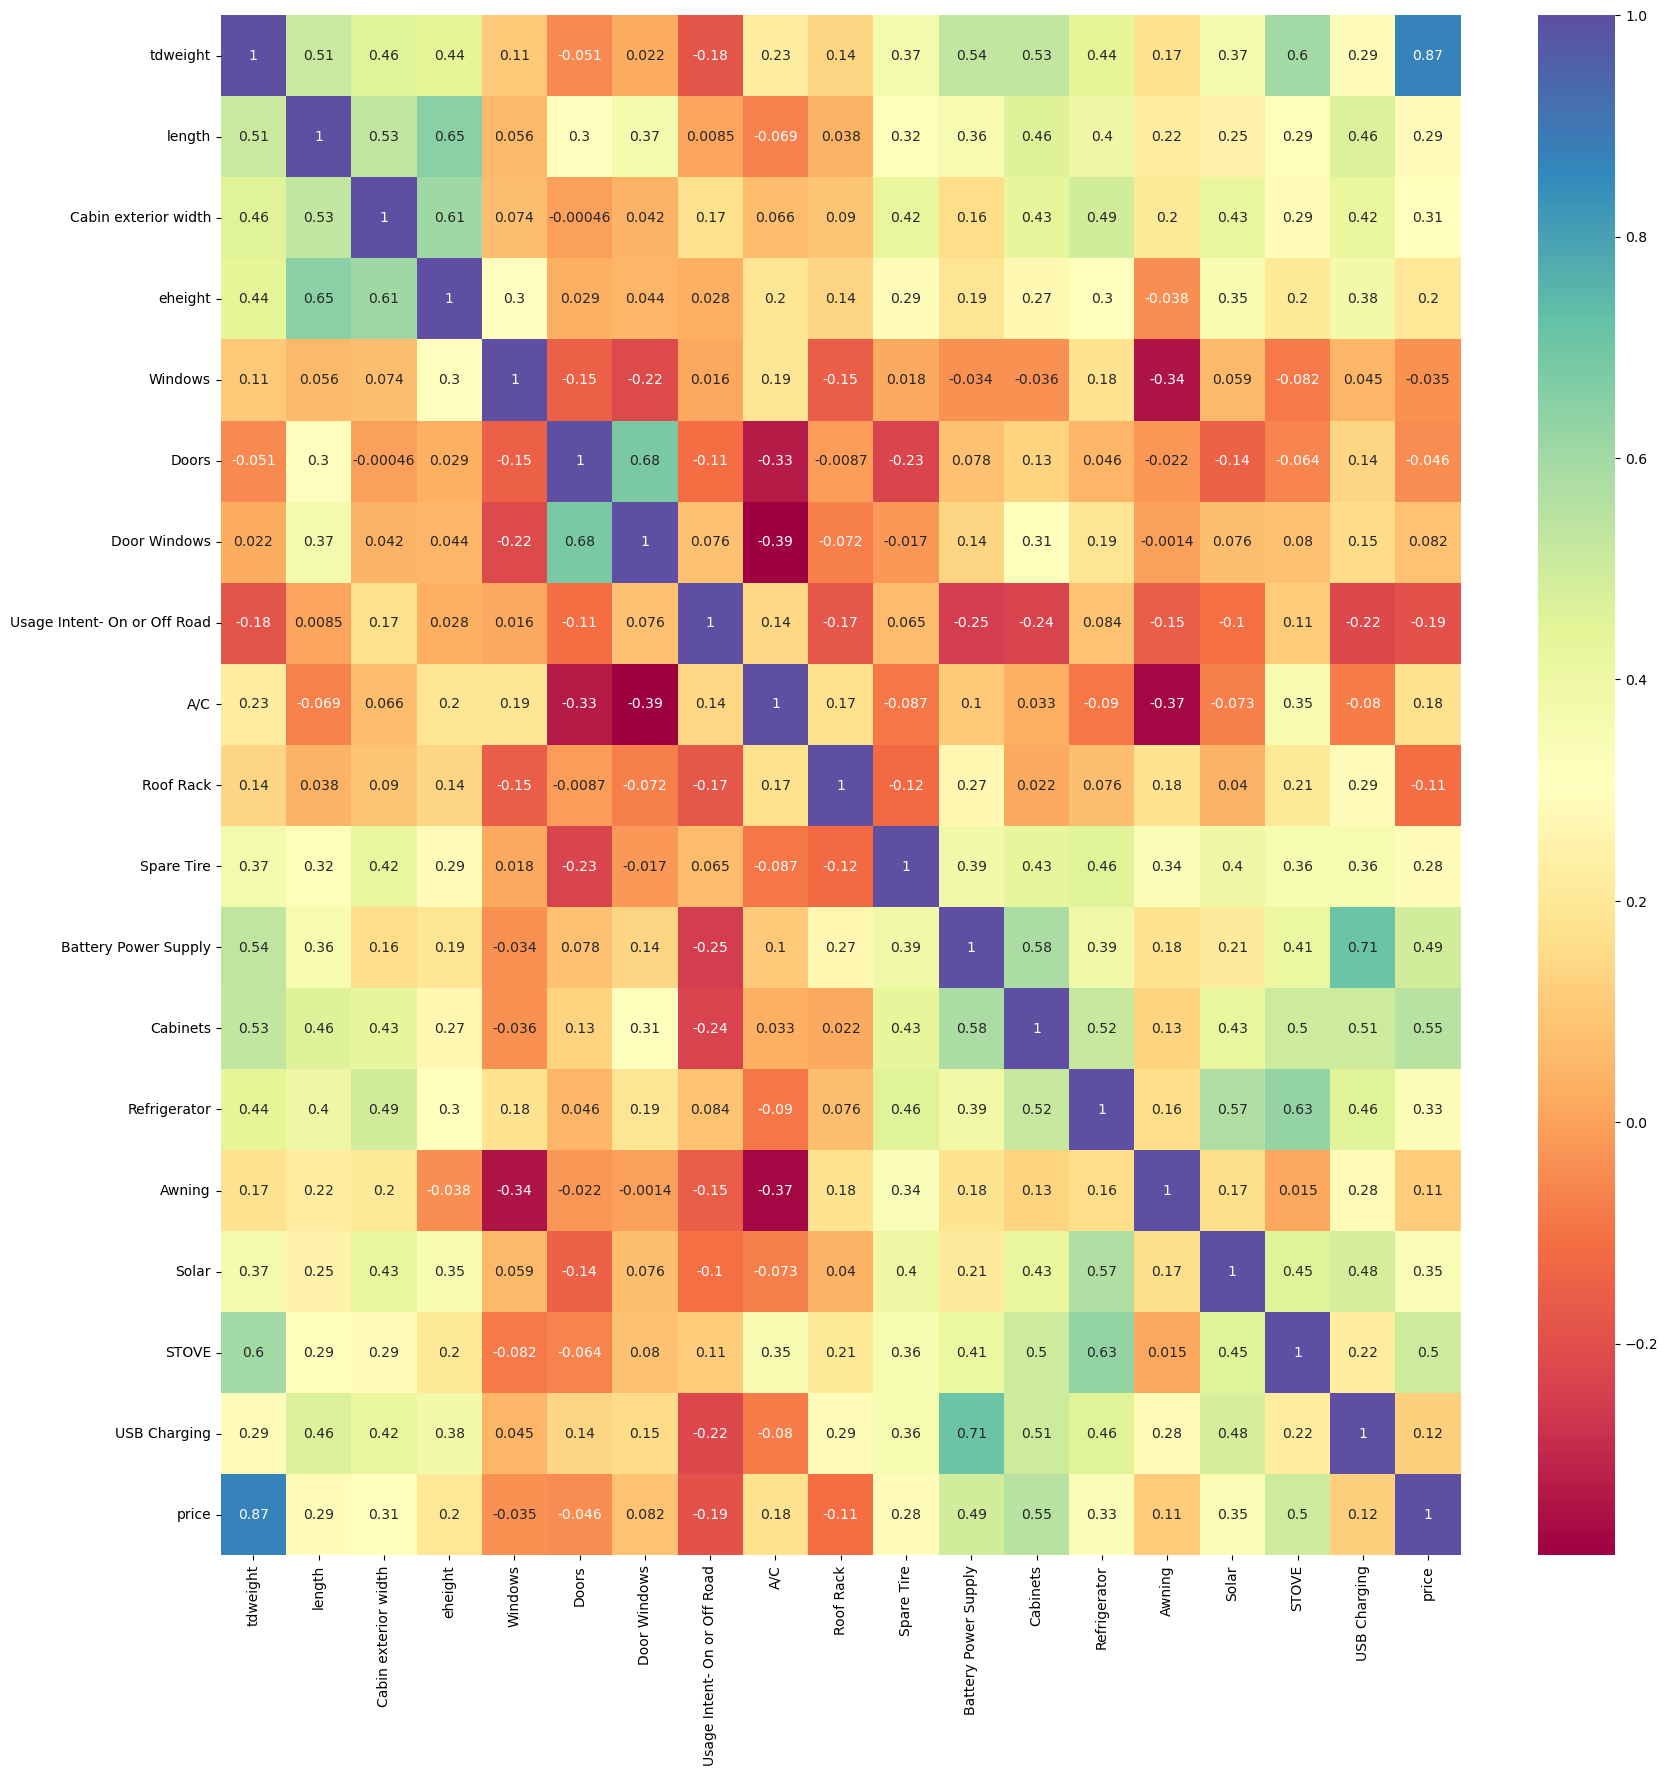

In [37]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="Spectral")

# Feature Engineering
This section is in progress while more feature data is collected.

In [38]:
#the last columns contain values we want to predict
data3=data.drop(data.index[91:])

In [39]:
#removing selected features with a negative correlation
X = data3.drop(['price', 'Door Windows', 'A/C'],axis=1)
y=data3['price']

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [41]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("MSE :", mean_squared_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=18) 

R^2 :  0.8352637872460676
MAE : 2753.656044791561
MSE : 10018318.126586068
RMSE: 3165.1726851130998


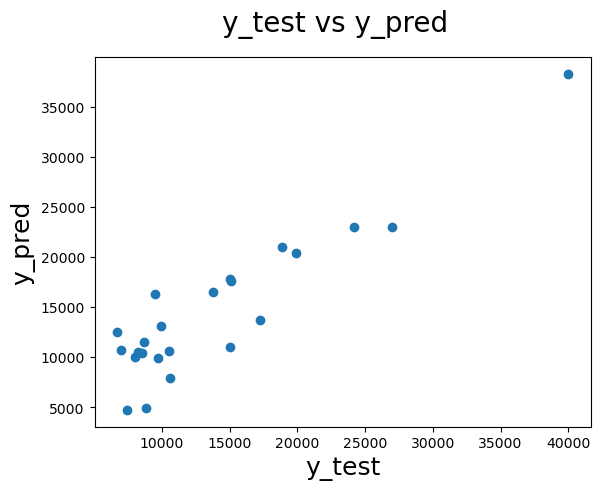

In [43]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.5918959054853217
MAE : 2889.3478260869565
MSE : 24818566.47826087
RMSE: 4981.823609709689


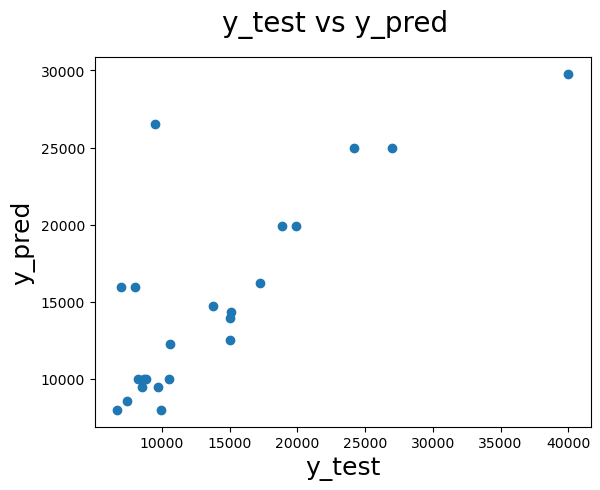

In [44]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5467008888574334
MAE : 4431.317000698126
MSE : 27567069.959950406
RMSE: 5250.435216241641


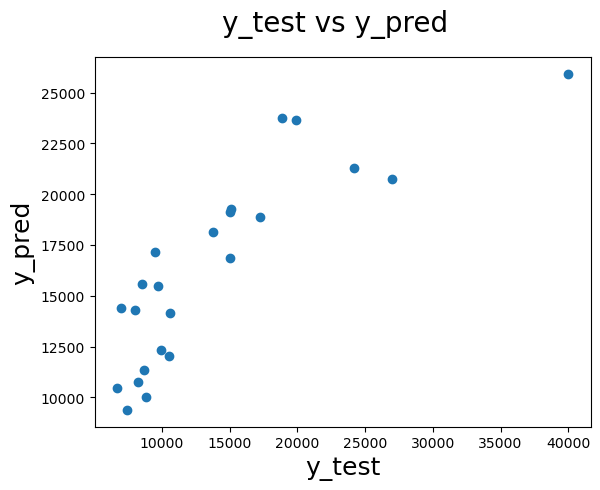

In [45]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.887383943937303
MAE : 2302.2133167690513
MSE : 6848667.071658287
RMSE: 2616.995810401363


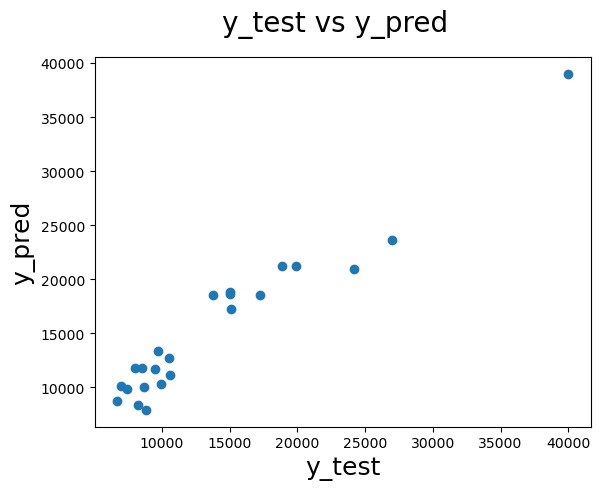

In [46]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.8385747440322279
MAE : 2777.3512617576034
MSE : 9816964.593974035
RMSE: 3133.2035672732845


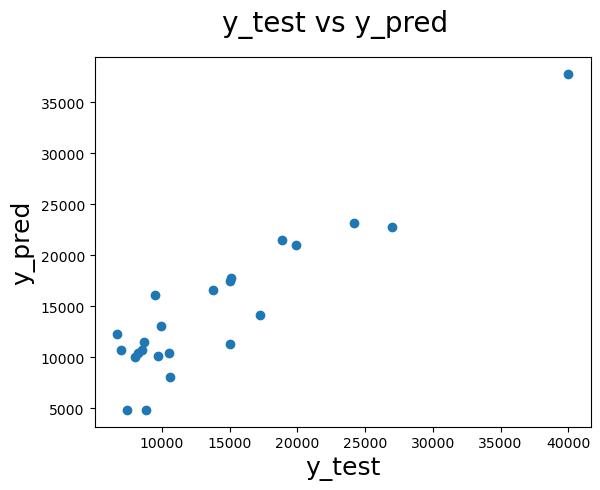

In [47]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.8386842028736582
MAE : 2779.999433149665
MSE : 9810307.930712907
RMSE: 3132.141109642557


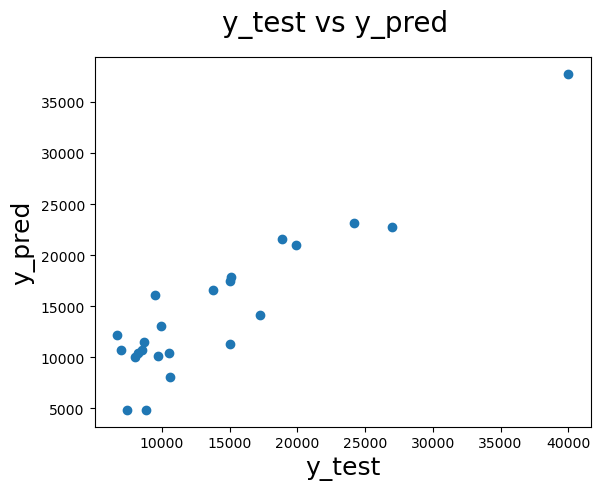

In [48]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.8421949071733819
MAE : 2746.408698860551
MSE : 9596806.89208249
RMSE: 3097.8713485363605


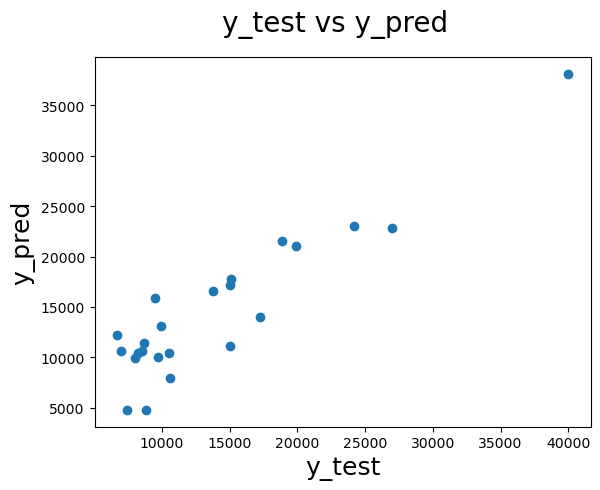

In [49]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.05197795117985926
MAE : 5593.261196972421
MSE : 63975306.95218974
RMSE: 7998.456535619215


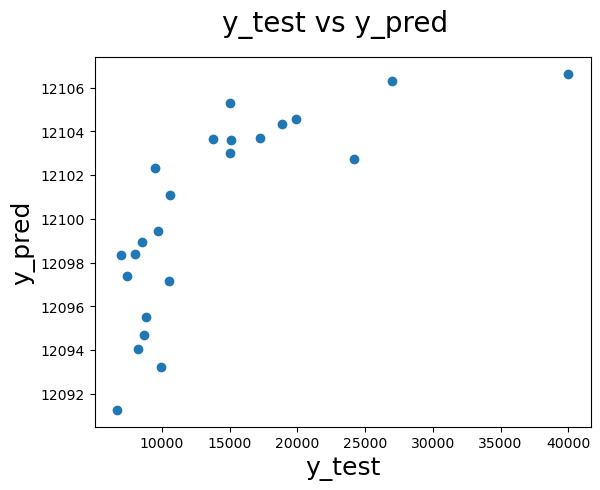

In [50]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.8074667352538503
MAE : 2504.2214168379946
MSE : 11708776.497480234
RMSE: 3421.808951049172


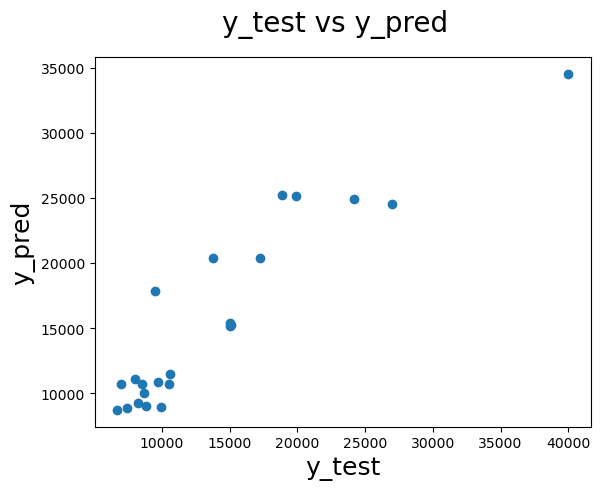

In [51]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.21115326 0.15071387 0.13040457 0.12605296 0.04068289 0.04171737
 0.04156048 0.03426487 0.03365129 0.03090586 0.02809215 0.02692624
 0.03192137 0.03084025 0.02203805 0.01907452]


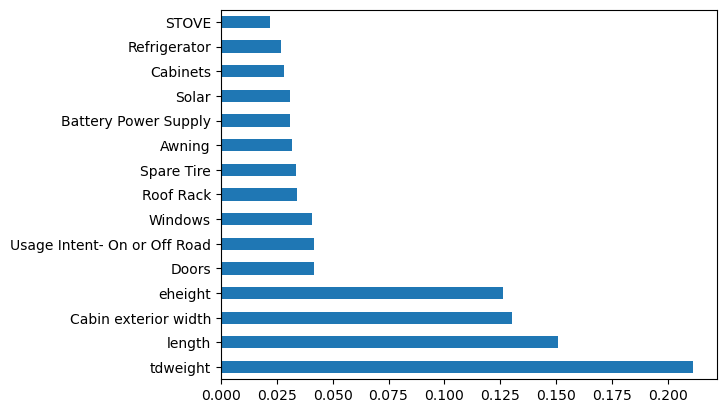

In [52]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [53]:
rfc=RandomForestRegressor(random_state=1)

In [54]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [55]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 500, 1000, 5000]})

In [56]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 15, 'n_estimators': 100}

R^2 :  0.767494151970341
MAE : 2697.6817391304344
MSE : 14139681.33000676
RMSE: 3760.2767624214525


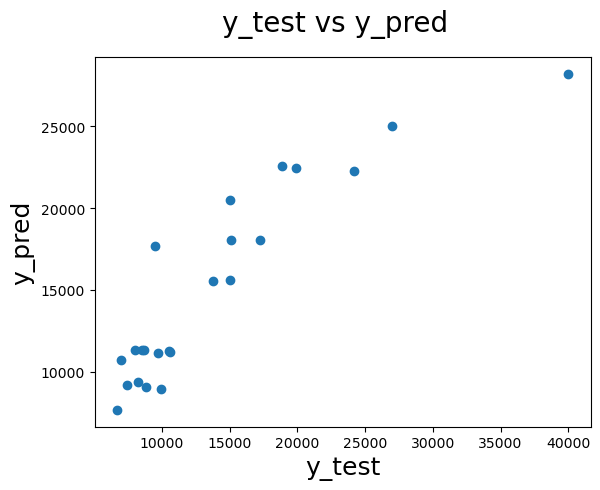

In [57]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=100, max_features='sqrt', max_depth=15, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

# Checking the value of interest

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [59]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

R^2 :  0.8958905905180893
MAE : 1044.9071975468974
MSE : 1545170.1424720767
RMSE: 1243.048728920985


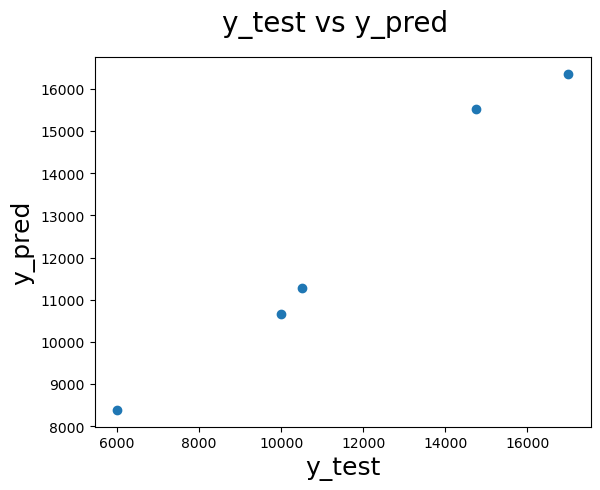

In [60]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

In [61]:
new_input = data.loc[91:]
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Door Windows,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Solar,STOVE,USB Charging,price
91,850,144.0,93.0,72.0,2,2,4,2,2,2,1,0,0,0,1,0,0,0,9995
92,850,144.0,93.0,72.0,2,2,4,2,2,2,1,0,0,0,1,0,0,2,9995
93,850,144.0,93.0,72.0,2,2,4,2,2,2,1,0,0,0,1,0,2,2,9995
94,850,144.0,93.0,72.0,2,2,4,2,2,2,1,0,0,0,1,2,2,2,9995
95,850,144.0,93.0,72.0,2,2,4,2,2,2,1,0,0,2,1,2,2,2,9995


In [62]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Awning', 'Door Windows'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,Windows,Doors,Usage Intent- On or Off Road,A/C,Roof Rack,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Solar,STOVE,USB Charging
91,850,144.0,93.0,72.0,2,2,2,2,2,1,0,0,0,0,0,0
92,850,144.0,93.0,72.0,2,2,2,2,2,1,0,0,0,0,0,2
93,850,144.0,93.0,72.0,2,2,2,2,2,1,0,0,0,0,2,2
94,850,144.0,93.0,72.0,2,2,2,2,2,1,0,0,0,2,2,2
95,850,144.0,93.0,72.0,2,2,2,2,2,1,0,0,2,2,2,2


In [63]:
new_input_scaled = scaler.fit_transform(new_input)

In [64]:
#CV?
new_output = final_model.predict(new_input_scaled)
new_output

array([12245.64      , 11526.53      , 13842.63      , 13958.42      ,
       13537.78666667])

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>